In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
# for running notebooks, plotting inline
%pylab inline
import pyccl as ccl # for generating weak lensing cross power spectra


Populating the interactive namespace from numpy and matplotlib


In [2]:
nbins = 2 # number of tomographic bins
# number of cross/auto angular power spectra
ncombinations = int(nbins*(nbins+1)/2)
nz = 1000 #redshift resolution
zbins = [(0.5, 0.7), (0.9, 1.1)]
z = np.linspace(0.5,1.1,nz)
ells = np.logspace(np.log10(10),np.log10(10000),1000)
# I think this is 1
delta_l = 1

dNdz_true = ccl.dNdzSmail(alpha = 1.3, beta = 1.5, z0=0.65)
# Assumes photo-z error is Gaussian with a bias is 0.05(1+z)
pz = ccl.PhotoZGaussian(sigma_z0=0.05)



In [3]:
def euclid_ccl(Omega_c, Omega_b=0.045, sigma8=0.83, n_s=0.963, h=0.71, mps='halofit'):
    """
    Generate C_ell as function of ell for a given Omega_c and Sigma8

    Inputs
        Omega_c -- float: CDM density 
        Sigma_8 -- float: sigma_8
        mps     -- string: model to use for matter power spectrum

    Assumed global variables
        z -- np.array: samples of z
        ells -- np.array: samples of ell
        dNdz_true -- ccl.dNdzSmail: dNdz distribution
        pz -- ccl.PhotoZGaussian: PhotoZ error
        nbins -- the amount of tomographic redshift bins

    Outputs
        Cls -- np.array, shape (nbins*(nbins-1)/2 + nbins, len(ell)): 
                Cross/Auto correlation shear spectra for the tomographic bins
        dNdzs -- np.array, shape (nbins,len(z):
                dNdz per redshift bin, for all redshifts

    """

    cosmo_fid = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s, matter_power_spectrum=mps)

    dNdzs = np.zeros((nbins, z.size))
    shears = []
    
    for i in range(nbins):
        # edges of 2 redshift bins
        zmin_b, zmax_b = zbins[i]
        print (f'Redshift bin {i}: {zmin_b} - {zmax_b}')
        # generate dNdz per bin
        dNdzs[i,:] = ccl.dNdz_tomog(z=z, zmin=zmin_b, zmax=zmax_b, pz_func=pz, dNdz_func = dNdz_true)
        # calculate the shear per bin
        gal_shapes = ccl.WeakLensingTracer(cosmo_fid, dndz=(z, dNdzs[i,:]))
        shears.append(gal_shapes)
        
    # calculate nbin*(nbin+1)/2 = 3 spectra from the shears
    Cls = []
    for i in range(nbins):
        for j in range(0,i+1):
            Cls.append(ccl.angular_cl(cosmo_fid, shears[i], shears[j], ells))
     
    return np.array(Cls), dNdzs

In [4]:
Cls, dNdzs = euclid_ccl(Omega_c = 0.211, Omega_b = 0.045, mps='halofit')
Cls_lin, dNdzs_lin = euclid_ccl(Omega_c = 0.211, Omega_b = 0.045, mps='linear')

Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1
Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1


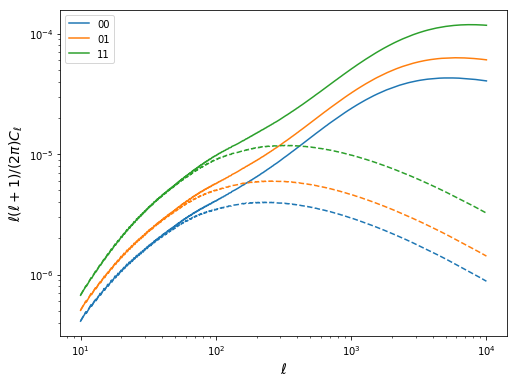

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
labels = ['00', '01', '11']
prop_cycle = plt.rcParamsDefault['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(ncombinations):
    # non linear mps
    plt.loglog(ells, ells*(ells+1)*Cls[i]/(2*np.pi),label=labels[i], color=colors[i])
    # linear as dashed
    plt.loglog(ells, ells*(ells+1)*Cls_lin[i]/(2*np.pi),ls='dashed', color=colors[i])

plt.xlabel('$\ell$',fontsize=14)
plt.ylabel('$\ell  (\ell + 1) / (2 \pi) C_\ell$',fontsize=14)
plt.legend()
plt.savefig('./angular_power_spectrum.png')
plt.show()

In [21]:
# Calculate derivatives numerically
def calculate_derivative(param):
    if param == 'Omega_c':
        dOmega = 0.002
        Omega_c = 0.211
        Cls_t, _ = euclid_ccl(Omega_c = Omega_c+dOmega, Omega_b = 0.045, mps='halofit')            
        logderiv = (np.log(Cls_t) - np.log(Cls)) / dOmega * Omega_c
        
    elif param == 'Omega_b':
        dOmega = 0.002
        Omega_b = 0.045
        Cls_t, _ = euclid_ccl(Omega_c = 0.211, Omega_b = 0.045+dOmega, mps='halofit')            
        logderiv = (np.log(Cls_t) - np.log(Cls)) / dOmega * Omega_b
        
    elif param == 'sigma8':
        dsigma = 0.002
        sigma8 = 0.83
        Cls_t, _ = euclid_ccl(Omega_c = 0.211, Omega_b = 0.045, sigma8=sigma8+dsigma, mps='halofit')            
        logderiv = (np.log(Cls_t) - np.log(Cls)) / dsigma * sigma8
        
    elif param == 'n_s':
        dns = 0.002
        n_s = 0.963
        Cls_t, _ = euclid_ccl(Omega_c = 0.211, Omega_b = 0.045, sigma8=0.83, n_s = n_s+dns, mps='halofit')            
        logderiv = (np.log(Cls_t) - np.log(Cls)) / dns * n_s
        
    elif param == 'h':
        dh = 0.01
        h = 0.71
        Cls_t, _ = euclid_ccl(Omega_c = 0.211, Omega_b = 0.045, sigma8=0.83, h = h+dh, mps='halofit')            
        logderiv = (np.log(Cls_t) - np.log(Cls)) / dh * h       
    
    else:
        print (f'Parameter {param} not implemented yet ')
    
    return logderiv


In [22]:
logderiv_Ob = calculate_derivative('Omega_b')
logderiv_Oc = calculate_derivative('Omega_c')
logderiv_s8 = calculate_derivative('sigma8')
logderiv_ns = calculate_derivative('n_s')
logderiv_h = calculate_derivative('h')

Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1
Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1
Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1
Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1
Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1


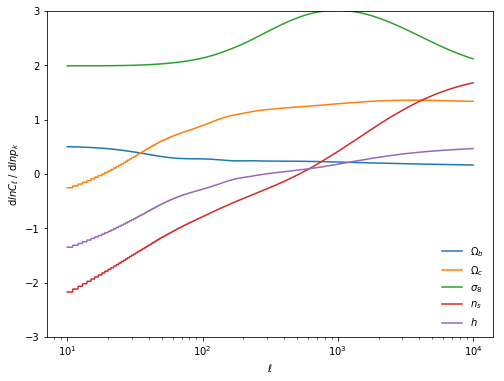

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(ells, logderiv_Ob[2], label='$\Omega_b$')
ax.plot(ells, logderiv_Oc[2], label='$\Omega_c$')
ax.plot(ells, logderiv_s8[2], label='$\sigma_8$')
ax.plot(ells, logderiv_ns[2], label='$n_s$')
ax.plot(ells, logderiv_h[2], label='$h$')
ax.set_xlabel('$\ell$')
ax.set_ylabel('d$ ln C_\ell$ / d$ ln p_k$')
ax.set_xscale('log')
ax.set_ylim(-3,3)
ax.legend(loc='lower right',frameon=False)
plt.savefig('./derivatives.png')
plt.show()

In [16]:
# 'normal' derivative wrt sigma8
dsigma = 0.002
sigma8 = 0.83
Cls_t, _ = euclid_ccl(Omega_c = 0.211, Omega_b = 0.045, sigma8=sigma8+dsigma, mps='halofit')            
deriv_s8 = (Cls_t - Cls) / dsigma

# derivative d log(Cl) / d(sigma8)
log1deriv_s8 = (np.log(Cls_t) - np.log(Cls)) / dsigma 

Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1


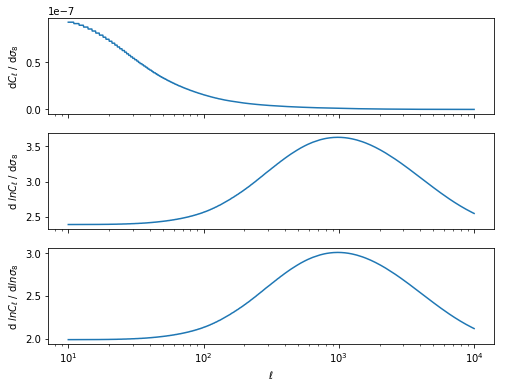

In [28]:
fig, axes = plt.subplots(3,1, figsize=(8,6), sharex=True)
ax = axes[0]
ax.plot(ells, deriv_s8[2])
ax.set_ylabel('d$ C_\ell$ / d$ \sigma_8$')

ax = axes[1]
ax.plot(ells, log1deriv_s8[2])
ax.set_ylabel('d $ ln C_\ell$ / d$ \sigma_8$')

ax = axes[2]
ax.plot(ells, log1deriv_s8[2] * sigma8)
ax.set_ylabel('d $ ln C_\ell$ / d$ ln \sigma_8$')

ax.set_xlabel('$\ell$')
ax.set_xscale('log')
# ax.set_ylim(-3,3)
# ax.legend(loc='upper right',frameon=False)
plt.savefig('./derivative_sigma8.png')
plt.show()

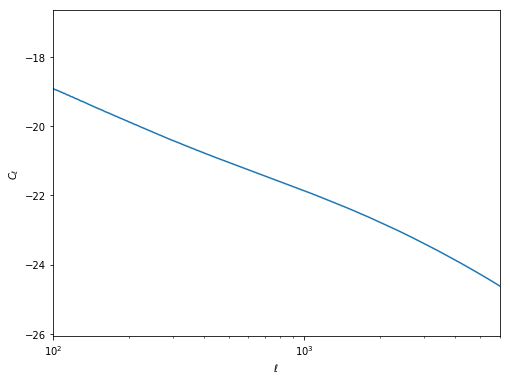

In [35]:
# ln(Cl)
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(ells, np.log(Cls)[2])
ax.set_xlabel('$\ell$')
ax.set_ylabel('$C_\ell$')
ax.set_xscale('log')
ax.set_xlim(100,6000)
plt.show()

In [32]:
# 'normal' derivative wrt Omega_C
domega = 0.002
Omega_c = 0.211
Cls_t, _ = euclid_ccl(Omega_c = Omega_c+domega, Omega_b = 0.045, sigma8=0.83, mps='halofit')            
deriv_Oc = (Cls_t - Cls) / domega

# derivative d log(Cl) / d(omega)
log1deriv_Oc = (np.log(Cls_t) - np.log(Cls)) / domega

Redshift bin 0: 0.5 - 0.7
Redshift bin 1: 0.9 - 1.1


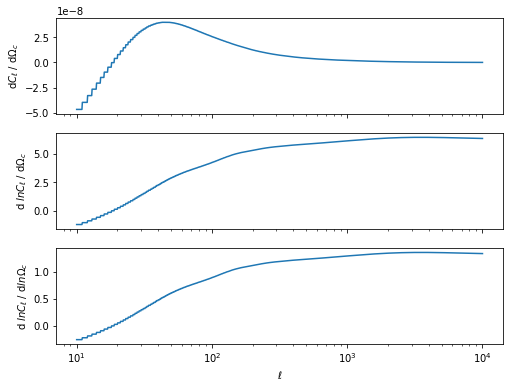

In [33]:
fig, axes = plt.subplots(3,1, figsize=(8,6), sharex=True)
ax = axes[0]
ax.plot(ells, deriv_Oc[2])
ax.set_ylabel('d$ C_\ell$ / d$ \Omega_c$')

ax = axes[1]
ax.plot(ells, log1deriv_Oc[2])
ax.set_ylabel('d $ ln C_\ell$ / d$ \Omega_c$')

ax = axes[2]
ax.plot(ells, log1deriv_Oc[2] * Omega_c)
ax.set_ylabel('d $ ln C_\ell$ / d$ ln \Omega_c$')

ax.set_xlabel('$\ell$')
ax.set_xscale('log')
# ax.set_ylim(-3,3)
# ax.legend(loc='upper right',frameon=False)
plt.savefig('./derivative_Omega_c.png')
plt.show()